In [1]:
import sys
import torch as t
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
sys.path.append('/workspace/wilson/Finite-groups/src')
from model import MLP3, MLP4, InstancedModule
from utils import *
from model_utils import *
from group_data import *
from jaxtyping import Float
from typing import Union
from einops import repeat
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
from llc import *
import gc

%load_ext autoreload
%autoreload 2

In [2]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [3]:
# path = '/workspace/models/2024_08_05_18_31_53_S_5__times_A_5__Z_2__'
# path = '/workspace/models/2024-12-19_01-41-15_S5_A5x2_MLP2_128_ubias_wd2e-5'
path = '/workspace/models/2025-01-31_00-19-35_S_5__times_A_5__Z_2__'
models, params = load_models(path, sel=slice(0, -1, 2))

  0%|          | 0/200 [00:00<?, ?it/s]/workspace/wilson/Finite-groups/src/model_utils.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(mode

In [4]:
data = GroupData(params)
loss_dict = test_loss(models[-1].to(device), data)

Intersection size: 7920/14400 (0.55)
Added 7920 elements from intersection
Added 0 elements from group 0: S(5)
Added 0 elements from group 1: times(A(5),Z(2))
Train set size: 7920/14400 (0.55)


In [6]:
LLC_PARAMS = {
    'eps': 8e-4,
    'beta': 1e3,
    'gamma': 1.,
    # 'chains': 3,
    'chains': 1,
    'cbatch_size': 1,
    'replacement': False,
    'behavioral': False,
    'epochs': 3000,
}

In [8]:
final_llc = get_llc(models[-1].to(device), data, **LLC_PARAMS)

SGLD:   0%|          | 0/3000 [00:00<?, ?it/s]

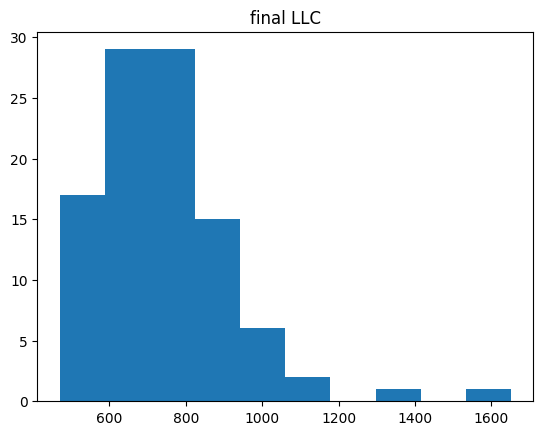

In [11]:
plt.hist(final_llc[0].detach().cpu())
plt.title('final LLC')
plt.show()

In [13]:
insts = []
insts.append(loss_dict['G0_loss'].argmin().item())
insts.append(loss_dict['G1_loss'].argmin().item())
insts.append(((loss_dict['G0_acc'] < 0.551) & (loss_dict['G1_acc'] < 0.551)).nonzero()[0,0].item())
insts.append(final_llc[0].argmax().item())
for inst in insts:
    print(inst, loss_dict['G0_acc'][inst], loss_dict['G1_acc'][inst])

0 tensor(1., device='cuda:0') tensor(0.5500, device='cuda:0') 31
1 tensor(0.5500, device='cuda:0') tensor(1., device='cuda:0') 43
2 tensor(0.5500, device='cuda:0') tensor(0.5500, device='cuda:0') 8
3 tensor(0.5500, device='cuda:0') tensor(0.5855, device='cuda:0') 18


In [6]:
# llcs = t.load('/workspace/wilson/Finite-groups/data/S5_A5x2_llcs.pt')
llcs = t.load('/workspace/wilson/Finite-groups/data/S5_A5x2_nobias_llcs.pt')
# llcs = {k.item(): v for k, v in llcs.items()}
insts = llcs.keys()

/tmp/ipykernel_5604/509496268.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  llcs = t.load('/workspace/wilson/Finite-groups/data/S5_A5x2_nobias_llcs.pt')


In [7]:
# llcs = dict()
g0_accs = dict()
g1_accs = dict()

In [8]:
for inst in insts:
    import gc; gc.collect()
    t.cuda.empty_cache()
    inst_models = MLP2.stack([model[inst].to(device) for model in tqdm(models, desc='stacking')]).to(device)
    inst_loss_dict = test_loss(inst_models, data)
    g0_accs[inst] = inst_loss_dict['G0_acc']
    g1_accs[inst] = inst_loss_dict['G1_acc']
    if inst in llcs:
        print('skipping', inst)
        continue
    llc , traces = get_llc(inst_models, data, **LLC_PARAMS)
    llcs[inst] = llc

stacking:   0%|          | 0/200 [00:00<?, ?it/s]

skipping 32


stacking:   0%|          | 0/200 [00:00<?, ?it/s]

skipping 68


stacking:   0%|          | 0/200 [00:00<?, ?it/s]

skipping 39


stacking:   0%|          | 0/200 [00:00<?, ?it/s]

skipping 73


In [18]:
# t.save(llcs, '/workspace/wilson/Finite-groups/data/S5_A5x2_llcs.pt')
t.save(llcs, '/workspace/wilson/Finite-groups/data/S5_A5x2_nobias_llcs.pt')

In [23]:
loss_dict['G0_acc'].shape

torch.Size([200])

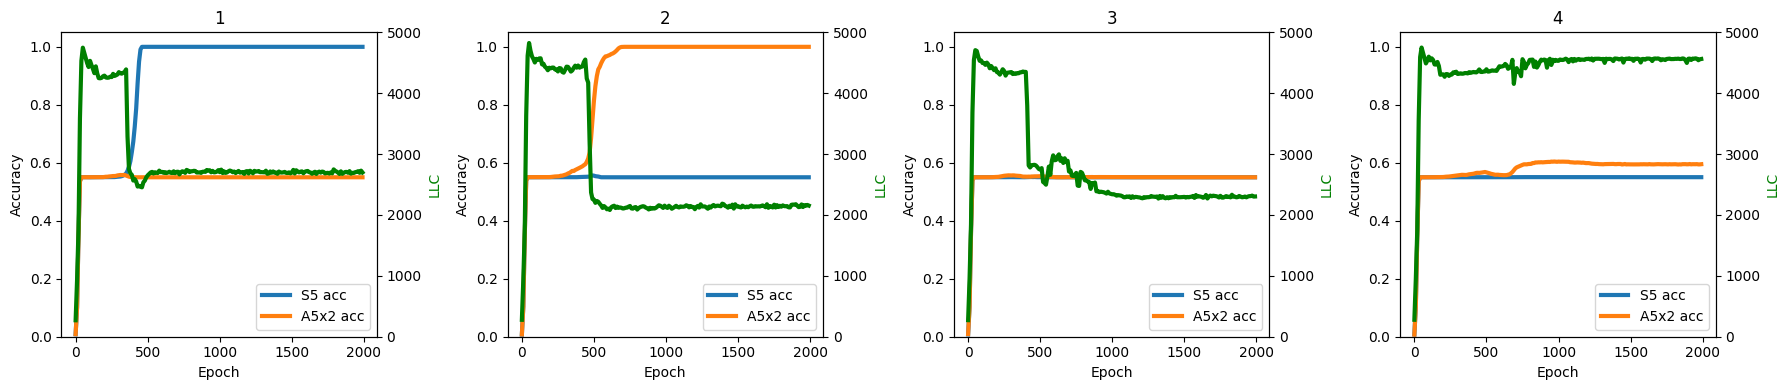

In [33]:
epochs = np.arange(0, 2000, 10)
fig, axs = plt.subplots(1, 4, figsize=(18, 4))
for i, inst in enumerate(llcs.keys()):
    # fig, ax1 = plt.subplots()
    ax1 = axs[i]
    ax1.plot(epochs, g0_accs[inst].detach().cpu(), label='S5 acc', linewidth=3)
    ax1.plot(epochs, g1_accs[inst].detach().cpu(), label='A5x2 acc', linewidth=3)
    ax1.legend(loc='lower right')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax2 = ax1.twinx()
    ax2.plot(epochs, llcs[inst].detach().cpu(), c='green', linewidth=3)
    ax2.set_ylabel('LLC', color='green')
    # ax2.tick_params(axis='y', labelcolor='green')
    ax1.set_ylim(0, 1.05)
    ax2.set_ylim(0, 5000)
    ax1.set_title(f'{i+1}')
fig.tight_layout()
plt.show()
    

In [4]:
dataset = GroupData(params)
del models

Intersection size: 7920/14400 (0.55)
Added 7920 elements from intersection
Added 0 elements from group 0: S(5)
Added 0 elements from group 1: times(A(5),Z(2))
Train set size: 7920/14400 (0.55)


In [5]:
llc_params = {
    'epochs': 2000,
    'eps': 8e-4,
    'beta': 1e3, 
    'gamma': 1., 
    'chains': 1, 
    'cbatch_size': 1, 
    'behavioral': True,
    'burnin': 0.8,
}

In [6]:
STRIDE = 10

In [7]:
#!mkdir /workspace/models/2024_08_05_18_31_53_S_5__times_A_5__Z_2__/llc

In [10]:
#for i in range(1000 // STRIDE):
for i in range(1, 1000 // STRIDE):
    print(i)
    models, _ = load_models(path, sel=slice(i * STRIDE, (i + 1) * STRIDE))
    model = models[0].stack(models).to(device)
    llc, _ = get_llc(model, dataset, **llc_params)
    llc = einops.rearrange(llc, '(epoch instance) -> epoch instance', epoch=STRIDE)
    for j in range(STRIDE):
        epoch = STRIDE * i + j
        filename = f'{path}/llc/{epoch*3:06d}.pt'  # ckpts were saved every 3 epochs
        #print(filename)
        t.save(llc[j], filename)
    gc.collect()
    t.cuda.empty_cache()

NameError: name 'STRIDE' is not defined

In [ ]:
t.load('/workspace/models/2024_08_05_18_31_53_S_5__times_A_5__Z_2__/llc/000027.pt').shape